In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("dschettler8845/brats-2021-task1")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'brats-2021-task1' dataset.
Path to dataset files: /kaggle/input/brats-2021-task1


In [2]:
import os
import nibabel as nib

import matplotlib.pyplot as plt


In [3]:
import tarfile

base_path = path   # the kagglehub path printed earlier
files = os.listdir(base_path)
files


['BraTS2021_00495.tar', 'BraTS2021_Training_Data.tar', 'BraTS2021_00621.tar']

In [4]:
import os, tarfile

base_path = "/kaggle/input/brats-2021-task1"
dest_path = "/kaggle/working/brats"

os.makedirs(dest_path, exist_ok=True)

files = os.listdir(base_path)

for f in files:
    if f.endswith(".tar"):
        tar_path = os.path.join(base_path, f)
        print("Extracting:", tar_path)

        with tarfile.open(tar_path) as tar:
            tar.extractall(dest_path)

print("Done!")
os.listdir(dest_path)


Extracting: /kaggle/input/brats-2021-task1/BraTS2021_00495.tar
Extracting: /kaggle/input/brats-2021-task1/BraTS2021_Training_Data.tar


/tmp/ipython-input-1979655043.py:16: DeprecationWarning: Python 3.14 will, by default, filter extracted tar archives and reject files or modify their metadata. Use the filter argument to control this behavior.
  tar.extractall(dest_path)


Extracting: /kaggle/input/brats-2021-task1/BraTS2021_00621.tar
Done!


['BraTS2021_01172',
 'BraTS2021_01572',
 'BraTS2021_01365',
 'BraTS2021_01475',
 'BraTS2021_01140',
 'BraTS2021_01207',
 'BraTS2021_00056',
 'BraTS2021_01518',
 'BraTS2021_01608',
 'BraTS2021_00204',
 'BraTS2021_00552',
 'BraTS2021_00251',
 'BraTS2021_00344',
 'BraTS2021_01411',
 'BraTS2021_01456',
 'BraTS2021_01171',
 'BraTS2021_00222',
 'BraTS2021_00727',
 'BraTS2021_00784',
 'BraTS2021_01222',
 'BraTS2021_00318',
 'BraTS2021_00554',
 'BraTS2021_00495_t1.nii.gz',
 'BraTS2021_00456',
 'BraTS2021_01495',
 'BraTS2021_00379',
 'BraTS2021_00014',
 'BraTS2021_01135',
 'BraTS2021_01244',
 'BraTS2021_01392',
 'BraTS2021_00373',
 'BraTS2021_00292',
 'BraTS2021_01656',
 'BraTS2021_00074',
 'BraTS2021_01385',
 'BraTS2021_00058',
 'BraTS2021_00176',
 'BraTS2021_01041',
 'BraTS2021_00591',
 'BraTS2021_00440',
 'BraTS2021_00782',
 'BraTS2021_01599',
 'BraTS2021_00149',
 'BraTS2021_01491',
 'BraTS2021_01356',
 'BraTS2021_01229',
 'BraTS2021_00025',
 'BraTS2021_01173',
 'BraTS2021_00274',
 'BraTS202

In [5]:
base_path = "/kaggle/working/brats"

patients = []

for item in os.listdir(base_path):
    item_path = os.path.join(base_path, item)

    # select ONLY directories
    if os.path.isdir(item_path) and item.startswith("BraTS2021_"):
        patients.append(item)


patients = sorted(patients)

print("Total Patients:", len(patients))
print("Example Case:", patients[0])


Total Patients: 1251
Example Case: BraTS2021_00000


In [6]:

#Lets load one case correctly
case = patients[0]
case_path = os.path.join(base_path, case)
print(case_path)


flair = nib.load(os.path.join(case_path, case + "_flair.nii.gz")).get_fdata()
t1 = nib.load(os.path.join(case_path, case + "_t1.nii.gz")).get_fdata()
t1ce = nib.load(os.path.join(case_path, case + "_t1ce.nii.gz")).get_fdata()
t2 = nib.load(os.path.join(case_path, case + "_t2.nii.gz")).get_fdata()
mask = nib.load(os.path.join(case_path, case + "_seg.nii.gz")).get_fdata()

print(flair.shape, mask.shape)


/kaggle/working/brats/BraTS2021_00000
(240, 240, 155) (240, 240, 155)


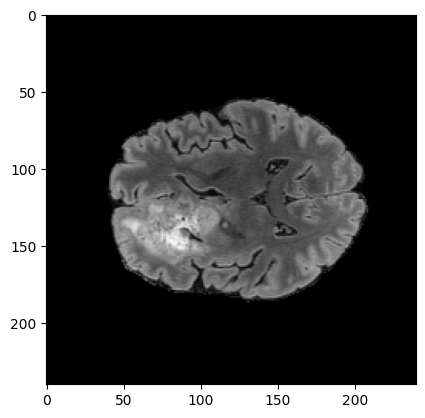

In [7]:
#lets visualize
slice_idx = flair.shape[2] // 2 #just taking the middle slice randomly.
plt.imshow(flair[:,:,slice_idx], cmap="gray")
plt.show()

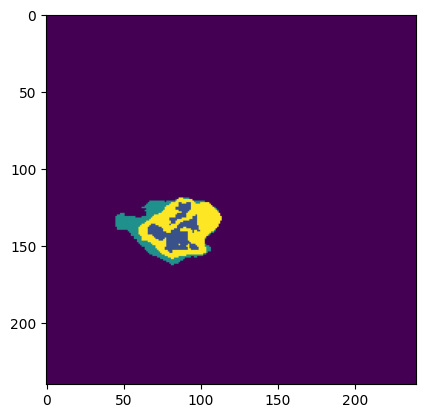

In [8]:
# the mask
plt.imshow(mask[:,:,slice_idx])
plt.show()


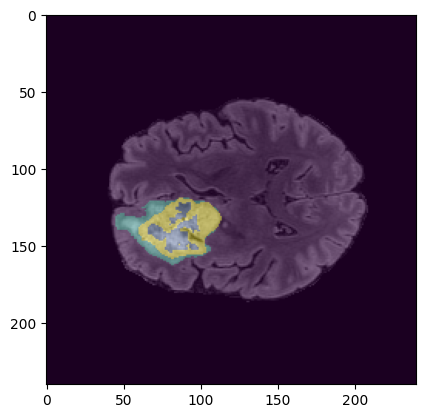

In [9]:
#overlaying the mask on the flair
plt.imshow(flair[:,:,slice_idx], cmap="gray")
plt.imshow(mask[:,:,slice_idx], alpha=0.4)
plt.show()

In [10]:
import numpy as np
import cv2 #for resizing
from tqdm import tqdm #for progress bar


In [11]:
def normalize(slice):
    slice = slice.astype(np.float32)
    if slice.max() != 0:
        slice = slice / slice.max()
    return slice

IMG_SIZE = 128

def resize_slice(img):
    return cv2.resize(img, (IMG_SIZE, IMG_SIZE), interpolation=cv2.INTER_NEAREST)


In [12]:
# for each patient -> Load the 4 modalities, and stack them (then the shape becomes (240,240,155,4)). Then iterate over each slice, and keep only the slice where the mask has tumor.
X = []
Y = []

for case in tqdm(patients[:50]):   # using few first for testing, later increase
    case_path = os.path.join(base_path, case)

    flair = nib.load(os.path.join(case_path, case + "_flair.nii.gz")).get_fdata()
    t1 = nib.load(os.path.join(case_path, case + "_t1.nii.gz")).get_fdata()
    t1ce = nib.load(os.path.join(case_path, case + "_t1ce.nii.gz")).get_fdata()
    t2 = nib.load(os.path.join(case_path, case + "_t2.nii.gz")).get_fdata()

    mask = nib.load(os.path.join(case_path, case + "_seg.nii.gz")).get_fdata()

    for slice_idx in range(flair.shape[2]):

        flair_slice = normalize(flair[:,:,slice_idx])
        t1_slice = normalize(t1[:,:,slice_idx])
        t1ce_slice = normalize(t1ce[:,:,slice_idx])
        t2_slice = normalize(t2[:,:,slice_idx])

        mask_slice = mask[:,:,slice_idx]

        # skiping blank mask slices
        if np.sum(mask_slice) == 0:
            continue

        # Resize
        flair_slice = resize_slice(flair_slice)
        t1_slice = resize_slice(t1_slice)
        t1ce_slice = resize_slice(t1ce_slice)
        t2_slice = resize_slice(t2_slice)

        mask_slice = resize_slice(mask_slice)

        # convert label 4 -> 3 (so classes become 0,1,2,3)
        mask_slice[mask_slice == 4] = 3

        # Stack modalities → (H,W,4)
        img = np.stack([flair_slice, t1_slice, t1ce_slice, t2_slice], axis=-1)

        X.append(img)
        Y.append(mask_slice)


#but U-Net wont take python lists, so we will have to convert it into numpy arrays
X = np.array(X, dtype=np.float32)
Y = np.array(Y, dtype=np.int32)

print("Before one-hot:", X.shape, Y.shape)

# One Hot encode Y (H,W) → (H,W,4)
from tensorflow.keras.utils import to_categorical
Y = to_categorical(Y, num_classes=4)

print("Final Dataset Shapes:")
print("X:", X.shape)
print("Y:", Y.shape)

#Now, X = all 2D slices (across many patients) where tumor exists
# Y = their matching tumor masks


100%|██████████| 50/50 [00:26<00:00,  1.86it/s]


Before one-hot: (3150, 128, 128, 4) (3150, 128, 128)
Final Dataset Shapes:
X: (3150, 128, 128, 4)
Y: (3150, 128, 128, 4)


In [13]:
#Now the fun part starts. The U-Net architecture.

import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose
from tensorflow.keras.layers import Concatenate, BatchNormalization, Activation
from tensorflow.keras.models import Model



In [14]:
def dice_coeff(y_true, y_pred, smooth=1):
    y_true_f = tf.reshape(y_true, [-1, 4])
    y_pred_f = tf.reshape(y_pred, [-1, 4])

    intersection = tf.reduce_sum(y_true_f * y_pred_f, axis=0)
    denom = tf.reduce_sum(y_true_f + y_pred_f, axis=0)

    dice = (2. * intersection + smooth) / (denom + smooth)
    return tf.reduce_mean(dice)

def dice_loss(y_true, y_pred):
    return 1 - dice_coeff(y_true, y_pred)

def iou_metric(y_true, y_pred, smooth=1):
    y_true_f = tf.reshape(y_true, [-1, 4])
    y_pred_f = tf.reshape(y_pred, [-1, 4])

    intersection = tf.reduce_sum(y_true_f * y_pred_f, axis=0)
    total = tf.reduce_sum(y_true_f + y_pred_f, axis=0)
    union = total - intersection

    iou = (intersection + smooth) / (union + smooth)
    return tf.reduce_mean(iou)



In [15]:
#I am using a 2D U-Net architecture originally proposed by Ronneberger et al. (“U-Net: Convolutional Networks for Biomedical Image Segmentation”, MICCAI 2015). Or atleast trying to "copy" them.
#The network consists of a contracting encoder path with 4 downsampling stages (64, 128, 256, 512 feature maps) and a symmetric decoder path with 4 upsampling stages and skip connections, with a 1024-filter bottleneck layer.

# MY Keras implementation follows the same design pattern and filter configuration, using “same” padding and 4-channel inputs for the BraTS MRI modalities, also similar to the U-Net Medical TensorFlow 2 reference implementation provided by NVIDIA.


def conv_block(inputs, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(inputs)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    return x

def encoder_block(inputs, num_filters):
    x = conv_block(inputs, num_filters)
    p = MaxPooling2D(pool_size=(2, 2))(x)
    return x, p

def decoder_block(inputs, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, kernel_size=(2, 2), strides=2, padding="same")(inputs)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x

def build_unet(input_shape=(128, 128, 4)):
    inputs = Input(input_shape)

    # Encoder path (contracting)
    s1, p1 = encoder_block(inputs, 64)    # 128 -> 64
    s2, p2 = encoder_block(p1, 128)       # 64 -> 32
    s3, p3 = encoder_block(p2, 256)       # 32 -> 16
    s4, p4 = encoder_block(p3, 512)       # 16 -> 8

    # Bottleneck
    b1 = conv_block(p4, 1024)

    # Decoder path (expanding)
    d1 = decoder_block(b1, s4, 512)       # 8 -> 16
    d2 = decoder_block(d1, s3, 256)       # 16 -> 32
    d3 = decoder_block(d2, s2, 128)       # 32 -> 64
    d4 = decoder_block(d3, s1, 64)        # 64 -> 128

    # Output layer: 4 channels, softmax for multi-class segmentation
    outputs = Conv2D(4, kernel_size=(1, 1), activation="softmax")(d4)


    model = Model(inputs, outputs, name="U-Net-Ronneberger-2D")
    return model

model = build_unet()
model.summary()


Model: "U-Net-Ronneberger-2D"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 4)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 128, 128,  │      2,368 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 128, 128,  │        256 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 128, 128,  │     36,928 │ activation[0][0]  │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        256 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 64, 64,    │          0 │ activation_1[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 64, 64,    │     73,856 │ max_pooling2d[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        512 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 64, 64,    │          0 │ batch_normalizat… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 64, 64,    │    147,584 │ activation_2[0][… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        512 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 64, 64,    │          0 │ batch_normalizat… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 32, 32,    │          0 │ activation_3[0][… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 32, 32,    │    295,168 │ max_pooling2d_1[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │      1,024 │ conv2d_4[0][0]  

 Total params: 31,056,068 (118.47 MB)

 Trainable params: 31,044,292 (118.42 MB)

 Non-trainable params: 11,776 (46.00 KB)

In [16]:

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss="categorical_crossentropy",
    metrics=[dice_coeff, iou_metric, "categorical_accuracy"]
)

In [17]:
#training and validation split

from sklearn.model_selection import train_test_split

X_train, X_val, Y_train, Y_val = train_test_split(
    X, Y, test_size=0.15, random_state=42
)

print(X_train.shape, X_val.shape)


(2677, 128, 128, 4) (473, 128, 128, 4)


In [18]:
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
#Automatically save the best model
checkpoint = ModelCheckpoint(
    "unet_brats.h5",
    monitor="val_dice_coeff",
    mode="max",
    save_best_only=True,
    verbose=1
)

# to slow down learning rate when model stops improving
lr_reducer = ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.5,
    patience=4,
    verbose=1
)
#Stop training EARLY when model stops improving
early_stop = EarlyStopping(
    monitor="val_loss",
    patience=10,
    restore_best_weights=True,
    verbose=1
)

#FINALLY: training the model.


history = model.fit(
    X_train, Y_train,
    validation_data=(X_val, Y_val),
    epochs=20,
    batch_size=8,
    callbacks=[checkpoint, lr_reducer, early_stop]
)
#note: Categorical accuracy means: Out of all pixels, what fraction did we classify into the correct label?
# and Dice Score is just “How well do predicted tumors overlap real tumors?”
# which is a better metric, because if the models learn to categorize only the background pixels(which are a large part of the image.)

Epoch 1/20
335/335 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step - categorical_accuracy: 0.8959 - dice_coeff: 0.2494 - iou_metric: 0.1976 - loss: 0.5061
Epoch 1: val_dice_coeff improved from -inf to 0.21836, saving model to unet_brats.h5


335/335 ━━━━━━━━━━━━━━━━━━━━ 130s 264ms/step - categorical_accuracy: 0.8961 - dice_coeff: 0.2495 - iou_metric: 0.1977 - loss: 0.5055 - val_categorical_accuracy: 0.9743 - val_dice_coeff: 0.2184 - val_iou_metric: 0.1825 - val_loss: 0.3960 - learning_rate: 1.0000e-04
Epoch 2/20
335/335 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - categorical_accuracy: 0.9883 - dice_coeff: 0.3858 - iou_metric: 0.3189 - loss: 0.1059
Epoch 2: val_dice_coeff improved from 0.21836 to 0.43527, saving model to unet_brats.h5


335/335 ━━━━━━━━━━━━━━━━━━━━ 53s 158ms/step - categorical_accuracy: 0.9883 - dice_coeff: 0.3859 - iou_metric: 0.3190 - loss: 0.1059 - val_categorical_accuracy: 0.9906 - val_dice_coeff: 0.4353 - val_iou_metric: 0.3596 - val_loss: 0.0689 - learning_rate: 1.0000e-04
Epoch 3/20
335/335 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - categorical_accuracy: 0.9915 - dice_coeff: 0.4798 - iou_metric: 0.3925 - loss: 0.0610
Epoch 3: val_dice_coeff improved from 0.43527 to 0.54458, saving model to unet_brats.h5


335/335 ━━━━━━━━━━━━━━━━━━━━ 52s 156ms/step - categorical_accuracy: 0.9915 - dice_coeff: 0.4798 - iou_metric: 0.3926 - loss: 0.0610 - val_categorical_accuracy: 0.9938 - val_dice_coeff: 0.5446 - val_iou_metric: 0.4464 - val_loss: 0.0405 - learning_rate: 1.0000e-04
Epoch 4/20
335/335 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - categorical_accuracy: 0.9931 - dice_coeff: 0.5566 - iou_metric: 0.4556 - loss: 0.0411
Epoch 4: val_dice_coeff improved from 0.54458 to 0.59653, saving model to unet_brats.h5


335/335 ━━━━━━━━━━━━━━━━━━━━ 56s 167ms/step - categorical_accuracy: 0.9931 - dice_coeff: 0.5567 - iou_metric: 0.4557 - loss: 0.0411 - val_categorical_accuracy: 0.9930 - val_dice_coeff: 0.5965 - val_iou_metric: 0.4902 - val_loss: 0.0340 - learning_rate: 1.0000e-04
Epoch 5/20
335/335 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - categorical_accuracy: 0.9940 - dice_coeff: 0.6284 - iou_metric: 0.5185 - loss: 0.0301
Epoch 5: val_dice_coeff improved from 0.59653 to 0.62392, saving model to unet_brats.h5


335/335 ━━━━━━━━━━━━━━━━━━━━ 58s 174ms/step - categorical_accuracy: 0.9940 - dice_coeff: 0.6284 - iou_metric: 0.5185 - loss: 0.0301 - val_categorical_accuracy: 0.9935 - val_dice_coeff: 0.6239 - val_iou_metric: 0.5182 - val_loss: 0.0284 - learning_rate: 1.0000e-04
Epoch 6/20
335/335 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - categorical_accuracy: 0.9945 - dice_coeff: 0.6764 - iou_metric: 0.5626 - loss: 0.0243
Epoch 6: val_dice_coeff improved from 0.62392 to 0.71326, saving model to unet_brats.h5


335/335 ━━━━━━━━━━━━━━━━━━━━ 62s 184ms/step - categorical_accuracy: 0.9945 - dice_coeff: 0.6764 - iou_metric: 0.5627 - loss: 0.0243 - val_categorical_accuracy: 0.9956 - val_dice_coeff: 0.7133 - val_iou_metric: 0.6014 - val_loss: 0.0188 - learning_rate: 1.0000e-04
Epoch 7/20
335/335 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - categorical_accuracy: 0.9955 - dice_coeff: 0.7255 - iou_metric: 0.6144 - loss: 0.0187
Epoch 7: val_dice_coeff improved from 0.71326 to 0.74025, saving model to unet_brats.h5


335/335 ━━━━━━━━━━━━━━━━━━━━ 62s 185ms/step - categorical_accuracy: 0.9955 - dice_coeff: 0.7255 - iou_metric: 0.6144 - loss: 0.0187 - val_categorical_accuracy: 0.9958 - val_dice_coeff: 0.7403 - val_iou_metric: 0.6297 - val_loss: 0.0164 - learning_rate: 1.0000e-04
Epoch 8/20
335/335 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - categorical_accuracy: 0.9954 - dice_coeff: 0.7429 - iou_metric: 0.6341 - loss: 0.0169
Epoch 8: val_dice_coeff improved from 0.74025 to 0.77468, saving model to unet_brats.h5


335/335 ━━━━━━━━━━━━━━━━━━━━ 67s 201ms/step - categorical_accuracy: 0.9954 - dice_coeff: 0.7430 - iou_metric: 0.6342 - loss: 0.0169 - val_categorical_accuracy: 0.9963 - val_dice_coeff: 0.7747 - val_iou_metric: 0.6691 - val_loss: 0.0136 - learning_rate: 1.0000e-04
Epoch 9/20
335/335 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - categorical_accuracy: 0.9962 - dice_coeff: 0.7869 - iou_metric: 0.6836 - loss: 0.0136
Epoch 9: val_dice_coeff improved from 0.77468 to 0.80812, saving model to unet_brats.h5


335/335 ━━━━━━━━━━━━━━━━━━━━ 78s 232ms/step - categorical_accuracy: 0.9962 - dice_coeff: 0.7869 - iou_metric: 0.6836 - loss: 0.0136 - val_categorical_accuracy: 0.9965 - val_dice_coeff: 0.8081 - val_iou_metric: 0.7072 - val_loss: 0.0117 - learning_rate: 1.0000e-04
Epoch 10/20
335/335 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - categorical_accuracy: 0.9966 - dice_coeff: 0.8129 - iou_metric: 0.7123 - loss: 0.0116
Epoch 10: val_dice_coeff did not improve from 0.80812
335/335 ━━━━━━━━━━━━━━━━━━━━ 52s 154ms/step - categorical_accuracy: 0.9966 - dice_coeff: 0.8129 - iou_metric: 0.7123 - loss: 0.0116 - val_categorical_accuracy: 0.9963 - val_dice_coeff: 0.7996 - val_iou_metric: 0.6996 - val_loss: 0.0117 - learning_rate: 1.0000e-04
Epoch 11/20
335/335 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - categorical_accuracy: 0.9958 - dice_coeff: 0.8078 - iou_metric: 0.7079 - loss: 0.0135
Epoch 11: val_dice_coeff improved from 0.80812 to 0.83195, saving model to unet_brats.h5


335/335 ━━━━━━━━━━━━━━━━━━━━ 77s 230ms/step - categorical_accuracy: 0.9958 - dice_coeff: 0.8078 - iou_metric: 0.7080 - loss: 0.0135 - val_categorical_accuracy: 0.9966 - val_dice_coeff: 0.8319 - val_iou_metric: 0.7358 - val_loss: 0.0108 - learning_rate: 1.0000e-04
Epoch 12/20
335/335 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - categorical_accuracy: 0.9968 - dice_coeff: 0.8404 - iou_metric: 0.7486 - loss: 0.0100
Epoch 12: val_dice_coeff improved from 0.83195 to 0.85092, saving model to unet_brats.h5


335/335 ━━━━━━━━━━━━━━━━━━━━ 74s 220ms/step - categorical_accuracy: 0.9968 - dice_coeff: 0.8404 - iou_metric: 0.7486 - loss: 0.0100 - val_categorical_accuracy: 0.9970 - val_dice_coeff: 0.8509 - val_iou_metric: 0.7613 - val_loss: 0.0093 - learning_rate: 1.0000e-04
Epoch 13/20
335/335 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - categorical_accuracy: 0.9971 - dice_coeff: 0.8603 - iou_metric: 0.7739 - loss: 0.0087
Epoch 13: val_dice_coeff did not improve from 0.85092
335/335 ━━━━━━━━━━━━━━━━━━━━ 51s 153ms/step - categorical_accuracy: 0.9971 - dice_coeff: 0.8603 - iou_metric: 0.7739 - loss: 0.0087 - val_categorical_accuracy: 0.9967 - val_dice_coeff: 0.8446 - val_iou_metric: 0.7527 - val_loss: 0.0099 - learning_rate: 1.0000e-04
Epoch 14/20
335/335 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - categorical_accuracy: 0.9971 - dice_coeff: 0.8694 - iou_metric: 0.7849 - loss: 0.0085
Epoch 14: val_dice_coeff improved from 0.85092 to 0.87822, saving model to unet_brats.h5


335/335 ━━━━━━━━━━━━━━━━━━━━ 79s 235ms/step - categorical_accuracy: 0.9971 - dice_coeff: 0.8694 - iou_metric: 0.7849 - loss: 0.0085 - val_categorical_accuracy: 0.9970 - val_dice_coeff: 0.8782 - val_iou_metric: 0.7982 - val_loss: 0.0084 - learning_rate: 1.0000e-04
Epoch 15/20
335/335 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - categorical_accuracy: 0.9973 - dice_coeff: 0.8821 - iou_metric: 0.8043 - loss: 0.0077
Epoch 15: val_dice_coeff improved from 0.87822 to 0.88077, saving model to unet_brats.h5


335/335 ━━━━━━━━━━━━━━━━━━━━ 69s 205ms/step - categorical_accuracy: 0.9973 - dice_coeff: 0.8821 - iou_metric: 0.8043 - loss: 0.0077 - val_categorical_accuracy: 0.9971 - val_dice_coeff: 0.8808 - val_iou_metric: 0.8021 - val_loss: 0.0083 - learning_rate: 1.0000e-04
Epoch 16/20
335/335 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - categorical_accuracy: 0.9975 - dice_coeff: 0.8916 - iou_metric: 0.8174 - loss: 0.0070
Epoch 16: val_dice_coeff did not improve from 0.88077
335/335 ━━━━━━━━━━━━━━━━━━━━ 52s 154ms/step - categorical_accuracy: 0.9975 - dice_coeff: 0.8916 - iou_metric: 0.8174 - loss: 0.0070 - val_categorical_accuracy: 0.9970 - val_dice_coeff: 0.8721 - val_iou_metric: 0.7906 - val_loss: 0.0082 - learning_rate: 1.0000e-04
Epoch 17/20
335/335 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - categorical_accuracy: 0.9974 - dice_coeff: 0.8933 - iou_metric: 0.8205 - loss: 0.0069
Epoch 17: val_dice_coeff improved from 0.88077 to 0.89895, saving model to unet_brats.h5


335/335 ━━━━━━━━━━━━━━━━━━━━ 75s 224ms/step - categorical_accuracy: 0.9974 - dice_coeff: 0.8933 - iou_metric: 0.8205 - loss: 0.0069 - val_categorical_accuracy: 0.9973 - val_dice_coeff: 0.8989 - val_iou_metric: 0.8284 - val_loss: 0.0073 - learning_rate: 1.0000e-04
Epoch 18/20
335/335 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - categorical_accuracy: 0.9976 - dice_coeff: 0.9069 - iou_metric: 0.8395 - loss: 0.0064
Epoch 18: val_dice_coeff did not improve from 0.89895
335/335 ━━━━━━━━━━━━━━━━━━━━ 52s 154ms/step - categorical_accuracy: 0.9976 - dice_coeff: 0.9069 - iou_metric: 0.8395 - loss: 0.0064 - val_categorical_accuracy: 0.9974 - val_dice_coeff: 0.8979 - val_iou_metric: 0.8268 - val_loss: 0.0073 - learning_rate: 1.0000e-04
Epoch 19/20
335/335 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - categorical_accuracy: 0.9978 - dice_coeff: 0.9103 - iou_metric: 0.8451 - loss: 0.0059
Epoch 19: val_dice_coeff improved from 0.89895 to 0.90387, saving model to unet_brats.h5


335/335 ━━━━━━━━━━━━━━━━━━━━ 69s 207ms/step - categorical_accuracy: 0.9978 - dice_coeff: 0.9103 - iou_metric: 0.8451 - loss: 0.0059 - val_categorical_accuracy: 0.9974 - val_dice_coeff: 0.9039 - val_iou_metric: 0.8357 - val_loss: 0.0071 - learning_rate: 1.0000e-04
Epoch 20/20
335/335 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - categorical_accuracy: 0.9979 - dice_coeff: 0.9158 - iou_metric: 0.8539 - loss: 0.0057
Epoch 20: val_dice_coeff did not improve from 0.90387
335/335 ━━━━━━━━━━━━━━━━━━━━ 52s 154ms/step - categorical_accuracy: 0.9979 - dice_coeff: 0.9158 - iou_metric: 0.8539 - loss: 0.0057 - val_categorical_accuracy: 0.9972 - val_dice_coeff: 0.8958 - val_iou_metric: 0.8236 - val_loss: 0.0074 - learning_rate: 1.0000e-04
Restoring model weights from the end of the best epoch: 19.


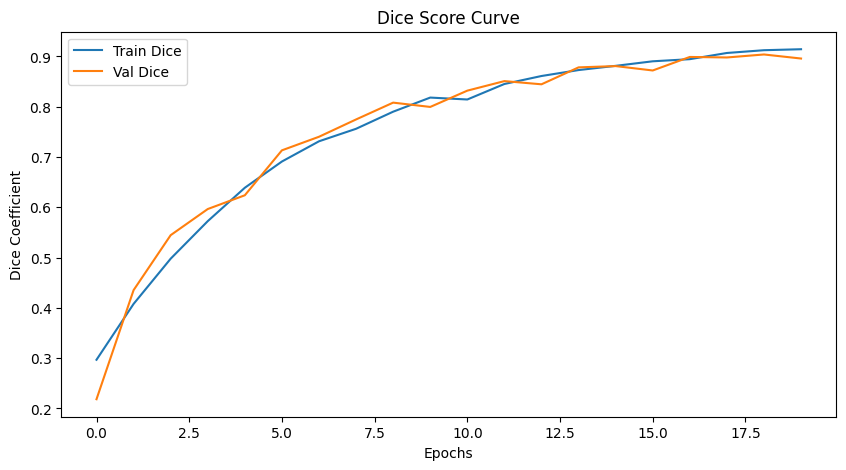

In [19]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.plot(history.history["dice_coeff"], label="Train Dice")
plt.plot(history.history["val_dice_coeff"], label="Val Dice")
plt.xlabel("Epochs")
plt.ylabel("Dice Coefficient")
plt.legend()
plt.title("Dice Score Curve")
plt.show()


In [20]:
import random
i = random.randint(0, len(X_val)-1)

test_img = X_val[i]
true_mask = Y_val[i]

pred_mask = model.predict(np.expand_dims(test_img, axis=0))[0]
pred_mask = (pred_mask > 0.5).astype("uint8")


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


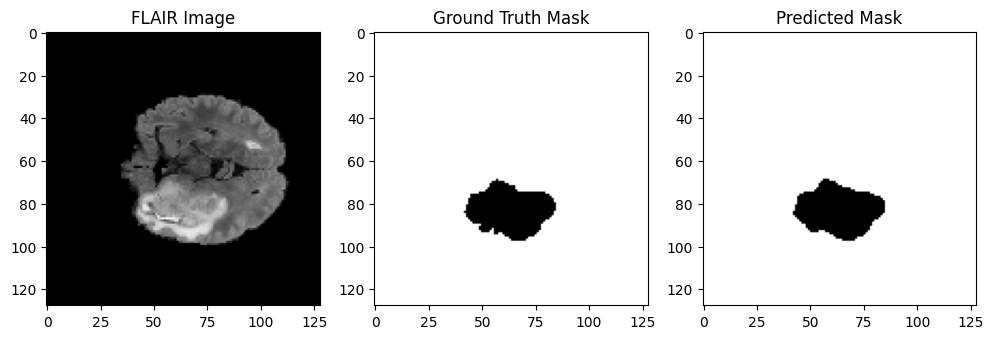

In [21]:
plt.figure(figsize=(12,4))

plt.subplot(1,3,1)
plt.imshow(test_img[:,:,0], cmap="gray")
plt.title("FLAIR Image")

plt.subplot(1,3,2)
plt.imshow(true_mask[:,:,0], cmap="gray")
plt.title("Ground Truth Mask")

plt.subplot(1,3,3)
plt.imshow(pred_mask[:,:,0], cmap="gray")
plt.title("Predicted Mask")

plt.show()


In [22]:

# BraTS labels
# 0 = background
# 1 = NCR / NET (Tumor Core)
# 2 = Edema
# 3 = Enhancing Tumor

COLOR_MAP = {
    0: (0, 0, 0),           # black
    1: (255, 0, 0),         # red
    2: (0, 255, 0),         # green
    3: (0, 0, 255)          # blue
}

def colorize_mask(mask):
    h, w = mask.shape
    color_mask = np.zeros((h,w,3), dtype=np.uint8)

    for label, color in COLOR_MAP.items():
        color_mask[mask == label] = color

    return color_mask


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


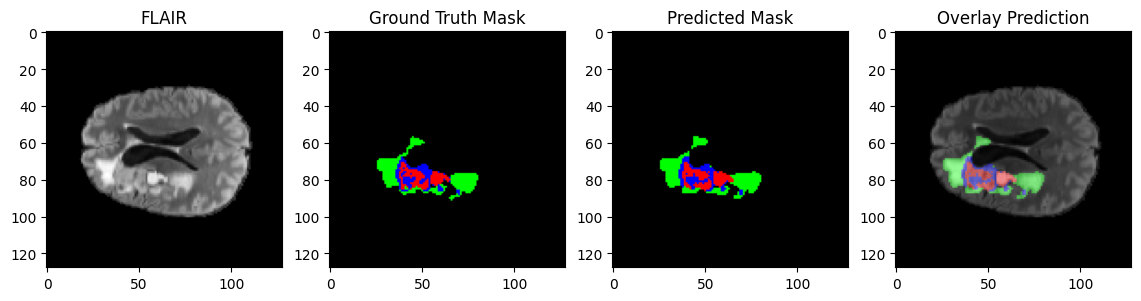

In [23]:
import random

i = random.randint(0, len(X_val)-1)

img = X_val[i]
true_mask = np.argmax(Y_val[i], axis=-1)

pred = model.predict(np.expand_dims(img, axis=0))[0]
pred_mask = np.argmax(pred, axis=-1)

true_colored = colorize_mask(true_mask)
pred_colored = colorize_mask(pred_mask)

plt.figure(figsize=(14,5))

plt.subplot(1,4,1)
plt.imshow(img[:,:,0], cmap="gray")
plt.title("FLAIR")

plt.subplot(1,4,2)
plt.imshow(true_colored)
plt.title("Ground Truth Mask")

plt.subplot(1,4,3)
plt.imshow(pred_colored)
plt.title("Predicted Mask")

plt.subplot(1,4,4)
plt.imshow(img[:,:,0], cmap="gray")
plt.imshow(pred_colored, alpha=0.4)
plt.title("Overlay Prediction")

plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


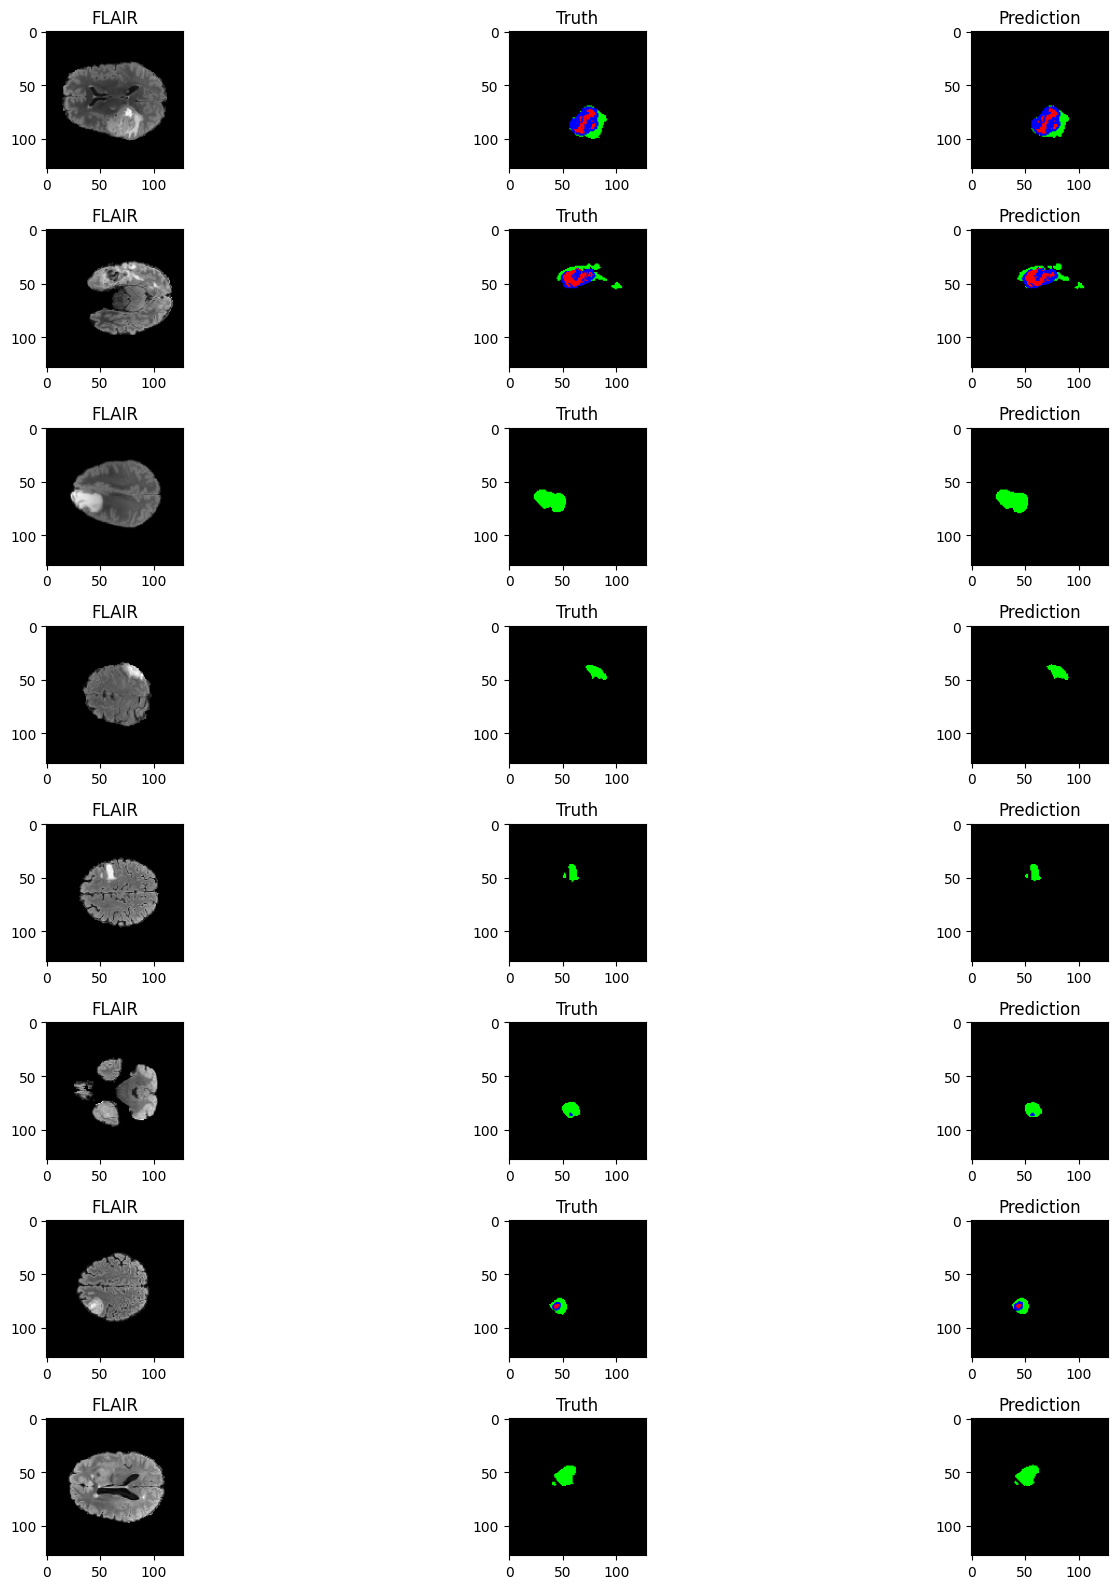

In [24]:
indices = np.random.choice(len(X_val), 8, replace=False)

plt.figure(figsize=(16,16))

for j, idx in enumerate(indices):
    img = X_val[idx]
    true_mask = np.argmax(Y_val[idx], axis=-1)
    pred = model.predict(np.expand_dims(img, axis=0))[0]
    pred_mask = np.argmax(pred, axis=-1)

    plt.subplot(8,3,3*j+1)
    plt.imshow(img[:,:,0], cmap="gray")
    plt.title("FLAIR")

    plt.subplot(8,3,3*j+2)
    plt.imshow(colorize_mask(true_mask))
    plt.title("Truth")

    plt.subplot(8,3,3*j+3)
    plt.imshow(colorize_mask(pred_mask))
    plt.title("Prediction")

plt.tight_layout()
plt.show()


In [25]:
import tensorflow as tf

def dice_per_class(y_true, y_pred, smooth=1e-6):
    y_true = tf.one_hot(y_true, 4)
    y_pred = tf.one_hot(y_pred, 4)

    dice_scores = []
    for c in range(4):
        y_t = tf.cast(y_true[...,c], tf.float32)
        y_p = tf.cast(y_pred[...,c], tf.float32)

        intersection = tf.reduce_sum(y_t * y_p)
        denom = tf.reduce_sum(y_t) + tf.reduce_sum(y_p)

        dice = (2. * intersection + smooth) / (denom + smooth)
        dice_scores.append(float(dice))

    return dice_scores


all_truth = []
all_pred = []

for i in range(len(X_val)):
    img = X_val[i]
    true_mask = np.argmax(Y_val[i], axis=-1)

    pred = model.predict(np.expand_dims(img, axis=0))[0]
    pred_mask = np.argmax(pred, axis=-1)

    all_truth.append(true_mask)
    all_pred.append(pred_mask)

all_truth = np.array(all_truth)
all_pred = np.array(all_pred)

d0, d1, d2, d3 = dice_per_class(all_truth, all_pred)

print("Dice Scores by Class:")
print(f"Background      : {d0:.3f}")
print(f"Tumor Core (1)  : {d1:.3f}")
print(f"Edema (2)       : {d2:.3f}")
print(f"Enhancing (3)   : {d3:.3f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


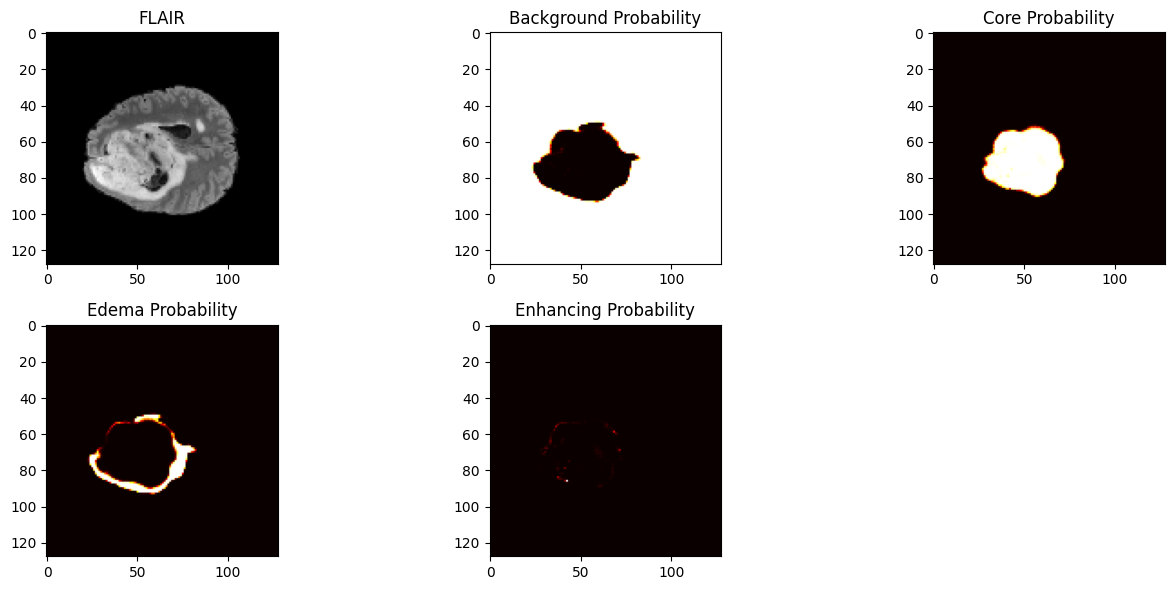

In [26]:
i = random.randint(0, len(X_val)-1)

img = X_val[i]
true_mask = np.argmax(Y_val[i], axis=-1)
pred = model.predict(np.expand_dims(img, axis=0))[0]

plt.figure(figsize=(14,6))

plt.subplot(2,3,1)
plt.imshow(img[:,:,0], cmap="gray")
plt.title("FLAIR")

for c, name in enumerate(["Background","Core","Edema","Enhancing"]):
    plt.subplot(2,3,c+2)
    plt.imshow(pred[:,:,c], cmap="hot")
    plt.title(f"{name} Probability")

plt.tight_layout()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


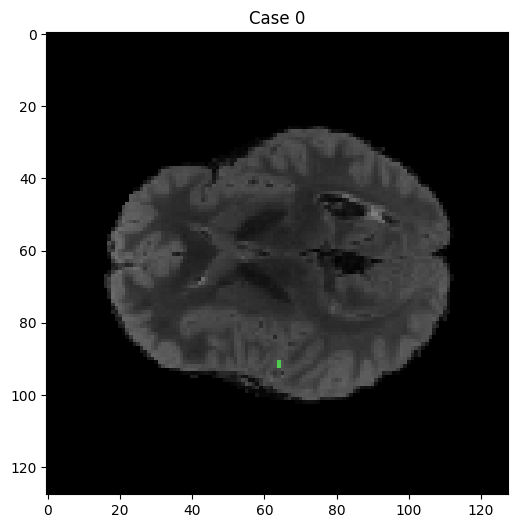

In [27]:
from matplotlib import pyplot as plt
from matplotlib import animation
from IPython.display import HTML

fig = plt.figure(figsize=(6,6))

frames = 30
index_list = np.linspace(0, len(X_val)-1, frames).astype(int)

def animate(i):
    plt.clf()

    img = X_val[index_list[i]]
    pred = model.predict(np.expand_dims(img, axis=0))[0]
    pred_mask = np.argmax(pred, axis=-1)

    plt.imshow(img[:,:,0], cmap="gray")
    plt.imshow(colorize_mask(pred_mask), alpha=0.5)
    plt.title(f"Case {index_list[i]}")

ani = animation.FuncAnimation(fig, animate, frames=frames, interval=500)

HTML(ani.to_jshtml())


Using patient: BraTS2021_00046
Volume Shape: (240, 240, 155)
Prepared 155 slices


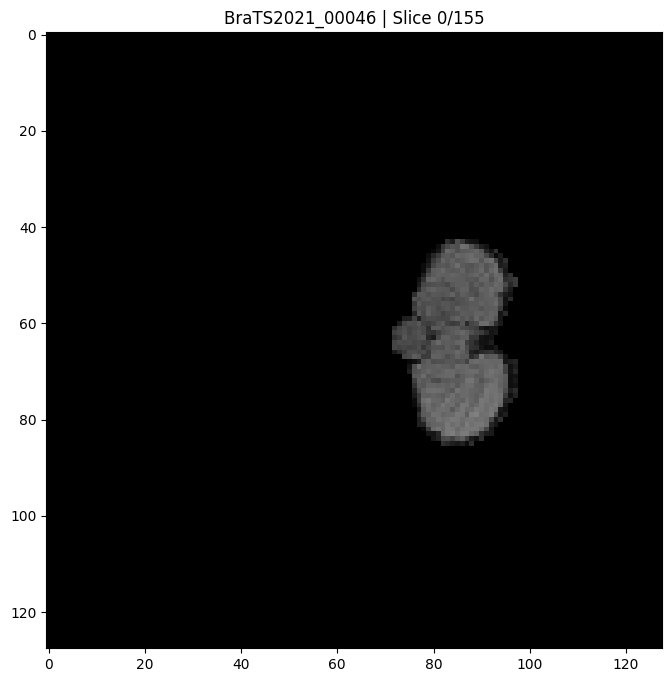

In [28]:
# Choose any patient folder name from your dataset
PATIENT_ID = patients[30]   # <-- pick any index or name
print("Using patient:", PATIENT_ID)

case_path = os.path.join(base_path, PATIENT_ID)

# Load modalities
flair = nib.load(os.path.join(case_path, PATIENT_ID + "_flair.nii.gz")).get_fdata()
t1 = nib.load(os.path.join(case_path, PATIENT_ID + "_t1.nii.gz")).get_fdata()
t1ce = nib.load(os.path.join(case_path, PATIENT_ID + "_t1ce.nii.gz")).get_fdata()
t2 = nib.load(os.path.join(case_path, PATIENT_ID + "_t2.nii.gz")).get_fdata()

mask_vol = nib.load(os.path.join(case_path, PATIENT_ID + "_seg.nii.gz")).get_fdata()

print("Volume Shape:", flair.shape)


slices = []
gt_masks = []
pred_masks = []

num_slices = flair.shape[2]

for i in range(num_slices):

    flair_slice = normalize(flair[:,:,i])
    t1_slice = normalize(t1[:,:,i])
    t1ce_slice = normalize(t1ce[:,:,i])
    t2_slice = normalize(t2[:,:,i])

    # resize
    fs = resize_slice(flair_slice)
    t1s = resize_slice(t1_slice)
    t1ces = resize_slice(t1ce_slice)
    t2s = resize_slice(t2_slice)

    img = np.stack([fs,t1s,t1ces,t2s], axis=-1)

    # save original flair (for visual clarity)
    slices.append(fs)

    # ground truth mask
    gt = resize_slice(mask_vol[:,:,i]).astype(np.uint8)
    gt_masks.append(gt)

    # prediction
    p = model.predict(np.expand_dims(img, axis=0), verbose=0)[0]
    p = np.argmax(p, axis=-1)
    pred_masks.append(p)

slices = np.array(slices)
gt_masks = np.array(gt_masks)
pred_masks = np.array(pred_masks)

print("Prepared", len(slices), "slices")

from matplotlib import pyplot as plt
from matplotlib import animation
from IPython.display import HTML

fig = plt.figure(figsize=(8,8))

def animate(i):
    plt.clf()

    base = slices[i]
    gt = colorize_mask(gt_masks[i])
    pred = colorize_mask(pred_masks[i])

    plt.imshow(base, cmap="gray")
    plt.imshow(pred, alpha=0.5)
    plt.title(f"{PATIENT_ID} | Slice {i}/{num_slices}")

ani = animation.FuncAnimation(fig, animate, frames=num_slices, interval=120)

HTML(ani.to_jshtml())
